In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
%pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 -q
%pip install -U tokenizers -q
%pip install peft transformers protobuf==3.20 bitsandbytes sentencepiece sacrebleu ipython datasets evaluate deepspeed einops wandb zstandard accelerate jsonlines trl tokenizers -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.38.2 requires tokenizers<0.19,>=0.14, but you have tokenizers 0.20.1 which is incompatible.
unbabel-comet 2.2.2 requires protobuf<5.0.0,>=4.24.4, but you have protobuf 3.20.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unbabel-comet 2.2.2 requires protobuf<5.0.0,>=4.24.4, but you have protobuf 3.20.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

from peft import PeftModel, PeftConfig

import matplotlib.pyplot as plt

from comet import download_model, load_from_checkpoint

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
import json

with open('data/translate_cpo_kiwi.json', 'r') as f:
    data = json.load(f)

In [14]:
def adequacy(en_tr, en_ref):
    return len(en_tr) / len(en_ref)

In [15]:
adequacy_score = [adequacy(item['mt'], item['ref']) for item in data]

Text(0.5, 1.0, 'Отношение длины перевода на EN к референсу EN')

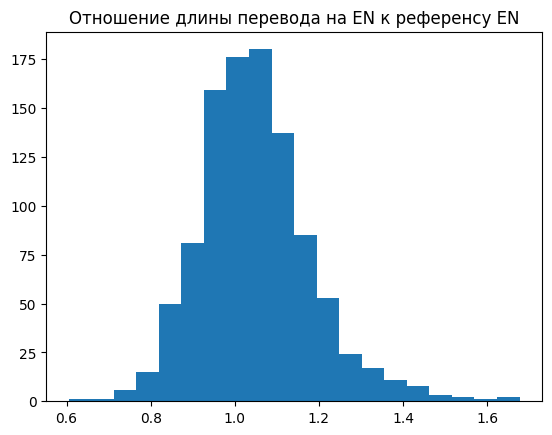

In [16]:
plt.hist(adequacy_score, bins = 20)
plt.title('Отношение длины перевода на EN к референсу EN')

In [ ]:
from typing import Dict, List
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
from comet import download_model, load_from_checkpoint

In [ ]:
model_path_xcomet = download_model("Unbabel/XCOMET-XL")
model_xcomet = load_from_checkpoint(model_path_xcomet)
model_xcomet = model_xcomet.to(device)

In [ ]:
def xcomet(data: List[Dict[str, str]]) -> List[float]:
    
    '''Format
    data = [
    {
        # Source, текст, который надо перевести, src
        "src": "В понедельник", 
        
        # Machine Translation
        "mt": "On Monday", 
        
        # Эталонный перевод, en
        "ref": "On Monday" 
    }'''
    
    
    xcomet_metric = model_xcomet.predict(data, batch_size=8, gpus=1)
    return xcomet_metric.scores

In [ ]:
xcomet_cpo_score = xcomet(data)

In [ ]:
plt.hist(xcomet_cpo_score, bins = 20)
plt.title('XCOMET')

In [ ]:
# cpo = 0.9626026108213093
# modpo = 0.9377332176762843
# alma = 0.9512363975580502

import numpy as np
np.mean(np.array(xcomet_cpo_score))

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch 

tokenizer = AutoTokenizer.from_pretrained("cointegrated/roberta-large-cola-krishna2020")
model_fluency = AutoModelForSequenceClassification.from_pretrained("cointegrated/roberta-large-cola-krishna2020")
model_fluency = model_fluency.to(device)

In [ ]:
def fluency(data: str) -> float:
    return torch.softmax(model_fluency(**tokenizer(data, return_tensors="pt").to(device)).logits, dim = -1)[0][0].detach().cpu().float()

In [ ]:
data_fluency = [item['mt'] for item in data]
data_fluency[0], data_fluency[1]

In [ ]:
fluency_cpo_score = [fluency(item) for item in data_fluency]

In [ ]:
import matplotlib.pyplot as plt

plt.hist(fluency_cpo_score, bins = 20)
plt.title('Fluency')

In [ ]:
# cpo = 0.9737626
# modpo = 0.93584627
# alma = 0.9457284 (??? 0.037422378 ???)


import numpy as np

np.mean(np.array(fluency_cpo_score))

In [ ]:
# from typing import Dict, List
# from comet import download_model, load_from_checkpoint

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path_kiwi = download_model("Unbabel/wmt23-cometkiwi-da-xxl")
model_kiwi = load_from_checkpoint(model_path_kiwi)
model_kiwi = model_kiwi.to(device)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 42868.10 MB. The target location /tmp/xdg_cache/huggingface/hub/models--Unbabel--wmt23-cometkiwi-da-xxl/blobs only has 35736.35 MB free disk space.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 42868.10 MB. The target location /tmp/xdg_cache/huggingface/hub/models--Unbabel--wmt23-cometkiwi-da-xxl/blobs only has 35736.35 MB free disk space.
  warnings.warn(
Fetching 6 files:  50%|█████     | 3/6 [03:33<03:33, 71.02s/it]


KeyboardInterrupt: 

In [ ]:
def kiwi(data: List[Dict[str, str]]) -> List[float]:
    
    '''Format
    data = [
    {
        # source original text, ru
        "src": "В понедельник",
        
        # machine translation, en
        "mt": "On Monday"
    }'''
    
    
    kiwi_metric = model_kiwi.predict(data, batch_size=8, gpus=1)
    return kiwi_metric

In [ ]:
data_kiwi = [(item['src'], item['mt']) for item in data]

In [ ]:
kiwi_cpo_score = kiwi(data_kiwi)